# Basic RAG for Tarot Reading

Retrieval-augmented generation (RAG) is an AI framework that synergizes the capabilities of LLMs and information retrieval systems. It’s useful to answer questions or generate content leveraging external knowledge. There are two main steps in RAG:

1. **Retrieval**: retrieve relevant information from a knowledge base with text embeddings stored in a vector store.
2. **Generation**: insert the relevant information to the prompt for the LLM to generate information.


In [1]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import requests
import pandas as pd
import numpy as np
import lancedb
import os

/Users/gracelin/Projects/mistral_playground/venv_mistral_playground/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the Mistral client
mistral_api_key = os.getenv('MISTRAL_API_KEY')
client = MistralClient(api_key=mistral_api_key)

### Get data

In [3]:
# Read tarot/oracle files
def get_data(file_path):
  df = pd.read_csv(file_path)

  # Convert to records so each row is a dictionary, and it's a list of dictionaries
  df_dict = df.to_dict(orient='records')

  # Combine keys and values into a single string
  texts = []
  for d in df_dict:
    text = ''
    for key, value in d.items():
      text += f"{key}: {value}; "
    texts.append(text.strip())

  return df_dict, texts

In [4]:
# The prisma vision tarot
file_path = 'data/prisma_visions_tarot.csv'
gentle_tarot_df_dict, gentle_tarot_texts = get_data(file_path)
len(gentle_tarot_df_dict), len(gentle_tarot_texts)

(81, 81)

In [5]:
# Your Wise animal body oracle
file_path = 'data/your_wise_animal_body_oracle.csv'
bloom_oracle_df_dict, bloom_oracle_texts = get_data(file_path)
len(bloom_oracle_df_dict), len(bloom_oracle_texts)

(37, 37)

In [6]:
gentle_tarot_df_dict[0].keys(), \
bloom_oracle_df_dict[0].keys()

(dict_keys(['Deck Name', 'Category', 'Card Name', 'Card Number', 'Image Description', 'Interpretation']),
 dict_keys(['Deck Name', 'Card Name', 'Card Category', 'Image Description', 'Interpretation']))

In [7]:
gentle_tarot_texts[0], \
bloom_oracle_texts[0]

('Deck Name: Prisma Visions Tarot; Category: Cups; Card Name: Ace of Chalices; Card Number: nan; Image Description: A chalice overflowing with water stands in the center of a pool beneath a starry night sky. Swirls of blue, teal, and white dominate the sky and water, while the chalice and surrounding trees feature warm oranges and yellows.; Interpretation: New beginnings, emotional abundance, joy, and fulfillment.;',
 'Deck Name: Your Wise Animal Body Oracle; Card Name: ATTEND; Card Category: GROUND; Image Description: Pink and purple gradient background. Inside a thin-lined, upside down triangle is a square containing a downward pointing triangle. Surrounding the shapes are spiraling lines that get wider apart as they move outward.; Interpretation: This card likely encourages grounding oneself, connecting with the earth, and finding stability.;')

In [8]:
# Combine texts
texts = gentle_tarot_texts + bloom_oracle_texts
len(texts)

118

In [9]:
df = pd.DataFrame(texts, columns=['text'])
df.head()

,text
0,Deck Name: Prisma Visions Tarot; Category: Cup...
1,Deck Name: Prisma Visions Tarot; Category: Cup...
2,Deck Name: Prisma Visions Tarot; Category: Cup...
3,Deck Name: Prisma Visions Tarot; Category: Cup...
4,Deck Name: Prisma Visions Tarot; Category: Cup...


## Split document into chunks

In a RAG system, it is crucial to split the document into smaller chunks so that it’s more effective to identify and retrieve the most relevant information in the retrieval process later. In our case, each row represents one card's information, which is also one chunk.

## Create embeddings for each text chunk
For each text chunk, we then need to create text embeddings, which are numeric representations of the text in the vector space. Words with similar meanings are expected to be in closer proximity or have a shorter distance in the vector space. To create an embedding, use Mistral’s embeddings API endpoint and the embedding model `mistral-embed`. We create a get_text_embedding to get the embedding from a single text chunk and then we use list comprehension to get text embeddings for all text chunks.

In [10]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    return embeddings_batch_response #.data[0].embedding

In [11]:
# Get embeddings in batches
# Might take some time
def get_embeddings_by_chunks(data, batch_size=50):
    batches = [data[x:x + batch_size] for x in range(0, len(data), batch_size)]
    embeddings_response = [get_text_embedding(c) for c in batches]
    return [d.embedding for e in embeddings_response for d in e.data]

# Get embeddings for all rows
df["vector"] = get_embeddings_by_chunks(texts)

In [12]:
df.head()

,text,vector
0,Deck Name: Prisma Visions Tarot; Category: Cup...,"[-0.038909912109375, 0.00914764404296875, 0.02..."
1,Deck Name: Prisma Visions Tarot; Category: Cup...,"[-0.04095458984375, 0.00315093994140625, 0.026..."
2,Deck Name: Prisma Visions Tarot; Category: Cup...,"[-0.040069580078125, 0.0002968311309814453, 0...."
3,Deck Name: Prisma Visions Tarot; Category: Cup...,"[-0.0435791015625, 0.01390838623046875, 0.0165..."
4,Deck Name: Prisma Visions Tarot; Category: Cup...,"[-0.036407470703125, 0.00720977783203125, 0.02..."


In [13]:
len(df['vector'][0])

1024

### TSNE to visualize the embedding results

In [14]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [15]:
df2 = df.copy()

In [16]:
def get_card_name(text):
  arr = text.split(';')
  for a in arr:
    if a.strip().startswith('Card Name'):
      return a.split(':')[1].strip()
  return None

df2['Card Name'] = df2['text'].apply(get_card_name)

# drop 'text' column
df2 = df2.drop('text', axis=1)

df2.head()

,vector,Card Name
0,"[-0.038909912109375, 0.00914764404296875, 0.02...",Ace of Chalices
1,"[-0.04095458984375, 0.00315093994140625, 0.026...",Two of Chalices
2,"[-0.040069580078125, 0.0002968311309814453, 0....",Three of Chalices
3,"[-0.0435791015625, 0.01390838623046875, 0.0165...",Four of Chalices
4,"[-0.036407470703125, 0.00720977783203125, 0.02...",Five of Chalices


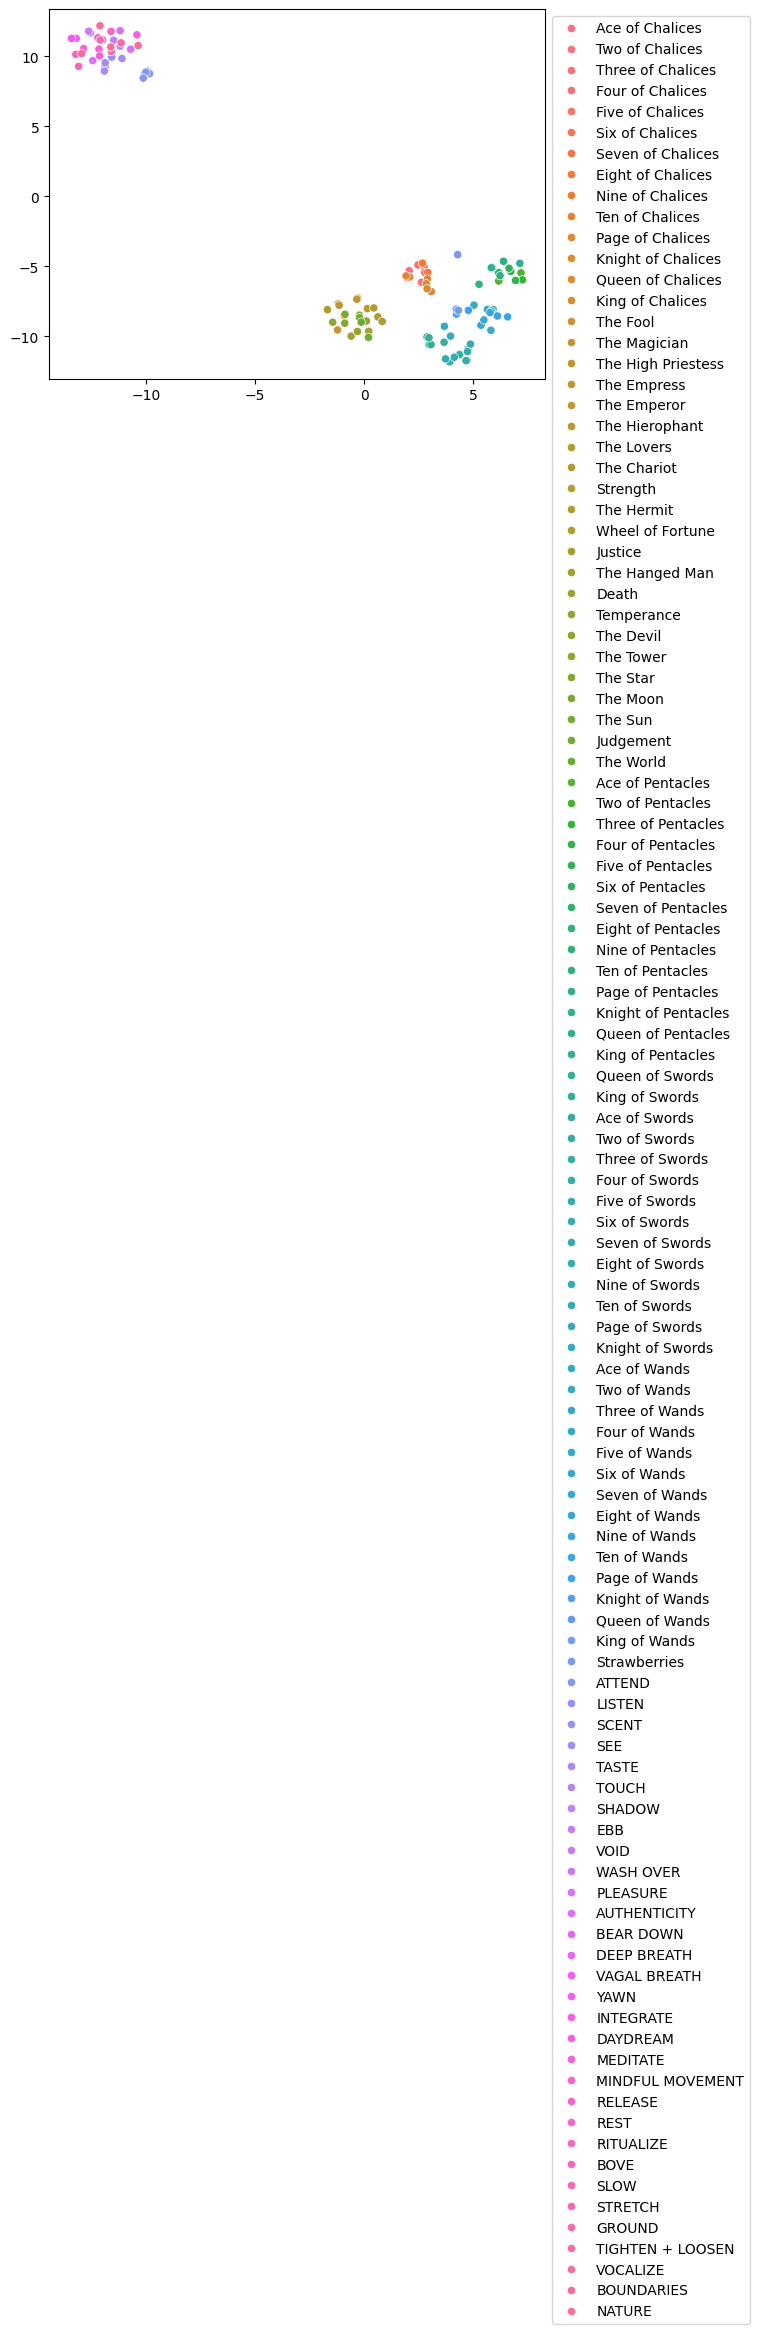

In [17]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df2['vector'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df2['Card Name'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

### Load into a vector database
Once we get the text embeddings, a common practice is to store them in a vector database for efficient processing and retrieval. There are several vector database to choose from. In our simple example, we are using an open-source vector database Faiss, which allows for efficient similarity search.  

With Faiss, we instantiate an instance of the Index class, which defines the indexing structure of the vector database. We then add the text embeddings to this indexing structure.


In [18]:
db = lancedb.connect("./lancedb")
table = db.create_table(
    "tarot_cards", 
    data=df, 
    mode="overwrite"
)

In [19]:
table.head()

pyarrow.Table
text: string
vector: fixed_size_list<item: float>[1024]
  child 0, item: float
----
text: [["Deck Name: Prisma Visions Tarot; Category: Cups; Card Name: Ace of Chalices; Card Number: nan; Image Description: A chalice overflowing with water stands in the center of a pool beneath a starry night sky. Swirls of blue, teal, and white dominate the sky and water, while the chalice and surrounding trees feature warm oranges and yellows.; Interpretation: New beginnings, emotional abundance, joy, and fulfillment.;","Deck Name: Prisma Visions Tarot; Category: Cups; Card Name: Two of Chalices; Card Number: nan; Image Description: Two figures embrace under a tree, their backs to the viewer. Warm orange, yellow, and red tones fill the sky and background, contrasting with the cooler blues and greens of the figures and foreground.; Interpretation: Partnership, connection, harmony, and mutual attraction.;","Deck Name: Prisma Visions Tarot; Category: Cups; Card Name: Three of Chalices; Car

#### Considerations:
- **Vector database**: When selecting a vector database, there are several factors to consider including speed, scalability, cloud management, advanced filtering, and open-source vs. closed-source.

### Create embeddings for a question
Whenever users ask a question, we also need to create embeddings for this question using the same embedding models as before.


In [20]:
def run_mistral(user_message, model="mistral-medium-latest"):
    messages = [
        ChatMessage(role="user", content=user_message)
    ]
    chat_response = client.chat(
        model=model,
        messages=messages
    )
    return (chat_response.choices[0].message.content)

In [21]:
question = """
What is the interpretation of the following cards?

Tarot cards: 3 of swords, death
Your wise animal body oracle cards: void, wash over
"""

In [22]:
# identify the cards mentioned
rsp = run_mistral("""
Identify all the cards in the message below. They may be tarot or oracle cards. They may be non-standard tarot cards.
Show the cards only, in comma-separated format, no notes or any other information.

Message: """+question)

rsp

'3 of swords, death, void, wash over'

In [23]:
cards = [c.strip() for c in rsp.split(',')]
cards

['3 of swords', 'death', 'void', 'wash over']

In [24]:
# get embeddings of requested cards
cards_embeddings = np.array([get_text_embedding(card).data[0].embedding for card in cards])
cards_embeddings.shape

(4, 1024)

In [25]:
cards_embeddings

array([[-0.029953  ,  0.03170776,  0.06018066, ..., -0.02897644,
        -0.01853943, -0.03079224],
       [-0.05535889,  0.00128269,  0.01238251, ..., -0.02259827,
         0.00425339, -0.02177429],
       [-0.00959778,  0.01316071,  0.02059937, ..., -0.03820801,
        -0.03050232, -0.00777435],
       [-0.00681686,  0.01556396,  0.04187012, ...,  0.01171112,
         0.01226044, -0.01138306]])

#### Considerations:
- Hypothetical Document Embeddings (HyDE): In some cases, the user’s question might not be the most relevant query to use for identifying the relevant context. Instead, it maybe more effective to generate a hypothetical answer or a hypothetical document based on the user’s query and use the embeddings of the generated text to retrieve similar text chunks.

### Retrieve similar chunks from the vector database
We can perform a search on the vector database with `index.search`, which takes two arguments: the first is the vector of the question embeddings, and the second is the number of similar vectors to retrieve. This function returns the distances and the indices of the most similar vectors to the question vector in the vector database. Then based on the returned indices, we can retrieve the actual relevant text chunks that correspond to those indices.


In [26]:
retrieved_chunks = []
for embedding in cards_embeddings:
    results = table.search(embedding).limit(2).to_pandas()
    # only take the first result of each card retrieved
    retrieved_chunks.append(results['text'][0])

In [27]:
retrieved_chunks

['Deck Name: Prisma Visions Tarot; Category: Swords; Card Name: Three of Swords; Card Number: nan; Image Description: Three swords piercing a heart in front of snow-covered mountains. Dark blue, gray, and touches of gold.; Interpretation: Heartbreak, betrayal, grief, sorrow, pain, separation;',
 'Deck Name: Prisma Visions Tarot; Category: Major arcana; Card Name: Death; Card Number: XIII; Image Description: A skeletal hand holds a white rose against a dark blue background with swirling patterns.; Interpretation: Transformation, endings, new beginnings, letting go of the old.;',
 'Deck Name: Your Wise Animal Body Oracle; Card Name: VOID; Card Category: nan; Image Description: A black circle on a blue-green gradient background.; Interpretation: Embracing emptiness, stillness, and potential.;',
 'Deck Name: Your Wise Animal Body Oracle; Card Name: WASH OVER; Card Category: nan; Image Description: Thin white lines make an abstract shape on a black circle on a pink and purple vertical gradi

#### Considerations:
- **Retrieval methods**: There are a lot different retrieval strategies. In our example, we are showing a simple similarity search with embeddings. Sometimes when there is metadata available for the data, it’s better to filter the data based on the metadata first before performing similarity search. There are also other statistical retrieval methods like TF-IDF and BM25 that use frequency and distribution of terms in the document to identify relevant text chunks.
- **Retrieved document**: Do we always retrieve individual text chunk as it is? Not always.
    - Sometimes, we would like to include more context around the actual retrieved text chunk. We call the actual retrieve text chunk “child chunk” and our goal is to retrieve a larger “parent chunk” that the “child chunk” belongs to.
    - On occasion, we might also want to provide weights to our retrieve documents. For example, a time-weighted approach would help us retrieve the most recent document.
    - One common issue in the retrieval process is the “lost in the middle” problem where the information in the middle of a long context gets lost. Our models have tried to mitigate this issue. For example, in the passkey task, our models have demonstrated the ability to find a "needle in a haystack" by retrieving a randomly inserted passkey within a long prompt, up to 32k context length. However, it is worth considering experimenting with reordering the document to determine if placing the most relevant chunks at the beginning and end leads to improved results.
  
### Combine context and question in a prompt and generate response

Finally, we can offer the retrieved text chunks as the context information within the prompt. Here is a prompt template where we can include both the retrieved text and user question in the prompt.



In [28]:
prompt = f"""
Context information is below.
---------------------
{'\n'.join(retrieved_chunks)}
---------------------
Answer the query by interpreting the cards with the context information above and any synchronicities through the images, colors, numbers, etc.

Query: {question}
Answer:
"""

In [29]:
# prompt

In [30]:
rsp = run_mistral(prompt, model="mistral-large-latest")
print(rsp)

The combination of these cards suggests a journey of emotional pain, transformation, and eventual healing. Let's break it down:

The Three of Swords from the Prisma Visions Tarot signifies heartbreak, betrayal, grief, or sorrow. The image of three swords piercing a heart is a powerful symbol of emotional pain. The dark blue and gray colors in the image further emphasize feelings of sadness and despair.

The Death card, also from the Prisma Visions Tarot, represents transformation, endings, new beginnings, and letting go of the old. Although the name and skeletal imagery might seem ominous, this card does not signify physical death but rather symbolizes the end of a phase or aspect of your life. The white rose held by the skeletal hand symbolizes new beginnings and hope amidst change.

The VOID card from the Your Wise Animal Body Oracle deck suggests embracing emptiness, stillness, and potential. This card encourages you to accept the current emptiness or silence in your life as it hold

#### Considerations:
- Prompting techniques: Most of the prompting techniques can be used in developing a RAG system as well. For example, we can use few-shot learning to guide the model’s answers by providing a few examples. Additionally, we can explicitly instruct the model to format answers in a certain way.
